# 準備

## Googleドライブのマウント

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## sys.pathの設定

以下では，Googleドライブのマイドライブ直下にDNN_codeフォルダを置くことを仮定しています．必要に応じて，パスを変更してください．

In [2]:
import sys
sys.path.append('/content/drive/My Drive/Study-AI/step4')

# simple RNN after
### バイナリ加算

iters:0
Loss:0.6278822560765682
Pred:[1 1 1 1 1 1 1 0]
True:[1 0 1 1 1 1 1 1]
71 + 120 = 254
------------
iters:100
Loss:0.9980340145694636
Pred:[1 1 0 1 0 0 0 0]
True:[0 1 1 0 1 0 1 1]
104 + 3 = 208
------------
iters:200
Loss:1.0254430752314825
Pred:[0 0 0 0 0 0 0 0]
True:[1 0 1 1 0 0 0 0]
84 + 92 = 0
------------
iters:300
Loss:0.9353175244497444
Pred:[0 0 1 0 1 1 1 0]
True:[0 0 1 1 1 1 1 0]
0 + 62 = 46
------------
iters:400
Loss:0.9774750582100168
Pred:[1 0 0 0 0 0 0 0]
True:[1 0 1 0 0 0 1 1]
94 + 69 = 128
------------
iters:500
Loss:0.9701393687620458
Pred:[1 1 1 1 1 1 0 1]
True:[0 1 1 1 0 1 1 0]
25 + 93 = 253
------------
iters:600
Loss:0.9496754489649772
Pred:[0 1 1 0 1 1 1 1]
True:[1 0 1 0 1 1 1 1]
112 + 63 = 111
------------
iters:700
Loss:0.9978531744849206
Pred:[1 1 1 1 1 1 0 1]
True:[1 0 0 0 1 1 1 0]
69 + 73 = 253
------------
iters:800
Loss:1.068734847749299
Pred:[1 1 1 1 1 1 1 0]
True:[1 0 0 0 0 1 0 1]
47 + 86 = 254
------------
iters:900
Loss:0.8808545896979458
Pred:[1 

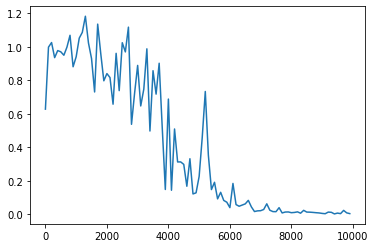

In [3]:
import numpy as np
from common import functions
import matplotlib.pyplot as plt


def d_tanh(x):
    return 1/(np.cosh(x) ** 2)

# データを用意
# 2進数の桁数
binary_dim = 8
# 最大値 + 1
largest_number = pow(2, binary_dim)
# largest_numberまで2進数を用意
binary = np.unpackbits(np.array([range(largest_number)],dtype=np.uint8).T,axis=1)

input_layer_size = 2
hidden_layer_size = 16
output_layer_size = 1

weight_init_std = 1
learning_rate = 0.1

iters_num = 10000
plot_interval = 100

# ウェイト初期化 (バイアスは簡単のため省略)
W_in = weight_init_std * np.random.randn(input_layer_size, hidden_layer_size)
W_out = weight_init_std * np.random.randn(hidden_layer_size, output_layer_size)
W = weight_init_std * np.random.randn(hidden_layer_size, hidden_layer_size)
# Xavier
# W_in = np.random.randn(input_layer_size, hidden_layer_size) / (np.sqrt(input_layer_size))
# W_out = np.random.randn(hidden_layer_size, output_layer_size) / (np.sqrt(hidden_layer_size))
# W = np.random.randn(hidden_layer_size, hidden_layer_size) / (np.sqrt(hidden_layer_size))
# He
# W_in = np.random.randn(input_layer_size, hidden_layer_size) / (np.sqrt(input_layer_size)) * np.sqrt(2)
# W_out = np.random.randn(hidden_layer_size, output_layer_size) / (np.sqrt(hidden_layer_size)) * np.sqrt(2)
# W = np.random.randn(hidden_layer_size, hidden_layer_size) / (np.sqrt(hidden_layer_size)) * np.sqrt(2)


# 勾配
W_in_grad = np.zeros_like(W_in)
W_out_grad = np.zeros_like(W_out)
W_grad = np.zeros_like(W)

u = np.zeros((hidden_layer_size, binary_dim + 1))
z = np.zeros((hidden_layer_size, binary_dim + 1))
y = np.zeros((output_layer_size, binary_dim))

delta_out = np.zeros((output_layer_size, binary_dim))
delta = np.zeros((hidden_layer_size, binary_dim + 1))

all_losses = []

for i in range(iters_num):
    
    # A, B初期化 (a + b = d)
    a_int = np.random.randint(largest_number/2)
    a_bin = binary[a_int] # binary encoding
    b_int = np.random.randint(largest_number/2)
    b_bin = binary[b_int] # binary encoding
    
    # 正解データ
    d_int = a_int + b_int
    d_bin = binary[d_int]
    
    # 出力バイナリ
    out_bin = np.zeros_like(d_bin)
    
    # 時系列全体の誤差
    all_loss = 0    
    
    # 時系列ループ
    for t in range(binary_dim):
        # 入力値
        X = np.array([a_bin[ - t - 1], b_bin[ - t - 1]]).reshape(1, -1)
        # 時刻tにおける正解データ
        dd = np.array([d_bin[binary_dim - t - 1]])
        
        u[:,t+1] = np.dot(X, W_in) + np.dot(z[:,t].reshape(1, -1), W)
        z[:,t+1] = functions.sigmoid(u[:,t+1])
#         z[:,t+1] = functions.relu(u[:,t+1])
#         z[:,t+1] = np.tanh(u[:,t+1])    
        y[:,t] = functions.sigmoid(np.dot(z[:,t+1].reshape(1, -1), W_out))


        #誤差
        loss = functions.mean_squared_error(dd, y[:,t])
        
        delta_out[:,t] = functions.d_mean_squared_error(dd, y[:,t]) * functions.d_sigmoid(y[:,t])        
        
        all_loss += loss

        out_bin[binary_dim - t - 1] = np.round(y[:,t])
    
    
    for t in range(binary_dim)[::-1]:
        X = np.array([a_bin[-t-1],b_bin[-t-1]]).reshape(1, -1)        

        delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_sigmoid(u[:,t+1])
#         delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_relu(u[:,t+1])
#         delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * d_tanh(u[:,t+1])    

        # 勾配更新
        W_out_grad += np.dot(z[:,t+1].reshape(-1,1), delta_out[:,t].reshape(-1,1))
        W_grad += np.dot(z[:,t].reshape(-1,1), delta[:,t].reshape(1,-1))
        W_in_grad += np.dot(X.T, delta[:,t].reshape(1,-1))
    
    # 勾配適用
    W_in -= learning_rate * W_in_grad
    W_out -= learning_rate * W_out_grad
    W -= learning_rate * W_grad
    
    W_in_grad *= 0
    W_out_grad *= 0
    W_grad *= 0
    

    if(i % plot_interval == 0):
        all_losses.append(all_loss)        
        print("iters:" + str(i))
        print("Loss:" + str(all_loss))
        print("Pred:" + str(out_bin))
        print("True:" + str(d_bin))
        out_int = 0
        for index,x in enumerate(reversed(out_bin)):
            out_int += x * pow(2, index)
        print(str(a_int) + " + " + str(b_int) + " = " + str(out_int))
        print("------------")

lists = range(0, iters_num, plot_interval)
plt.plot(lists, all_losses, label="loss")
plt.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
## [try] weight_init_stdやlearning_rate, hidden_layer_sizeを変更してみよう


## [try] 重みの初期化方法を変更してみよう
Xavier, He

## [try] 中間層の活性化関数を変更してみよう
ReLU(勾配爆発を確認しよう)<br>
tanh(numpyにtanhが用意されている。導関数をd_tanhとして作成しよう)

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

iters:0
Loss:1.0351623909788166
Pred:[0 0 0 0 0 0 0 0]
True:[0 1 1 1 1 1 0 0]
32 + 92 = 0
------------
iters:100
Loss:1.0622502481957994
Pred:[1 1 1 1 1 1 1 1]
True:[1 0 1 0 0 0 1 1]
43 + 120 = 255
------------
iters:200
Loss:0.9950215630161603
Pred:[1 1 1 1 1 1 1 1]
True:[1 1 0 1 0 0 1 0]
111 + 99 = 255
------------
iters:300
Loss:0.9786438100946605
Pred:[0 0 1 1 1 0 0 1]
True:[0 1 0 1 1 0 1 0]
33 + 57 = 57
------------
iters:400
Loss:1.0549173220681705
Pred:[0 0 0 0 0 0 0 0]
True:[1 1 0 1 0 1 1 1]
125 + 90 = 0
------------
iters:500
Loss:0.9761835034764158
Pred:[0 0 0 1 0 1 0 0]
True:[0 1 0 1 1 1 0 0]
70 + 22 = 20
------------
iters:600
Loss:0.9165853606286163
Pred:[0 0 0 0 0 0 0 0]
True:[0 0 1 0 0 0 1 1]
24 + 11 = 0
------------
iters:700
Loss:1.0479539500536172
Pred:[0 0 0 0 0 0 0 0]
True:[1 1 0 0 1 1 1 0]
123 + 83 = 0
------------
iters:800
Loss:0.9415274058541292
Pred:[1 1 1 1 1 1 1 1]
True:[0 1 1 1 1 1 1 0]
48 + 78 = 255
------------
iters:900
Loss:1.0101737518588798
Pred:[0 0 0

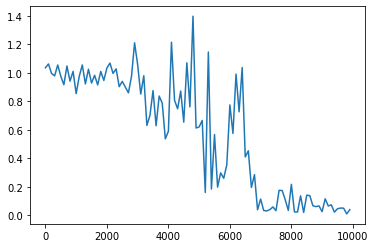

In [4]:
import numpy as np
from common import functions
import matplotlib.pyplot as plt


def d_tanh(x):
    return 1/(np.cosh(x) ** 2)

# データを用意
# 2進数の桁数
binary_dim = 8
# 最大値 + 1
largest_number = pow(2, binary_dim)
# largest_numberまで2進数を用意
binary = np.unpackbits(np.array([range(largest_number)],dtype=np.uint8).T,axis=1)

input_layer_size = 2
hidden_layer_size = 16
output_layer_size = 1

weight_init_std = 1
learning_rate = 0.1

iters_num = 10000
plot_interval = 100

# ウェイト初期化 (バイアスは簡単のため省略)
# W_in = weight_init_std * np.random.randn(input_layer_size, hidden_layer_size)
# W_out = weight_init_std * np.random.randn(hidden_layer_size, output_layer_size)
# W = weight_init_std * np.random.randn(hidden_layer_size, hidden_layer_size)
# Xavier
W_in = np.random.randn(input_layer_size, hidden_layer_size) / (np.sqrt(input_layer_size))
W_out = np.random.randn(hidden_layer_size, output_layer_size) / (np.sqrt(hidden_layer_size))
W = np.random.randn(hidden_layer_size, hidden_layer_size) / (np.sqrt(hidden_layer_size))
# He
# W_in = np.random.randn(input_layer_size, hidden_layer_size) / (np.sqrt(input_layer_size)) * np.sqrt(2)
# W_out = np.random.randn(hidden_layer_size, output_layer_size) / (np.sqrt(hidden_layer_size)) * np.sqrt(2)
# W = np.random.randn(hidden_layer_size, hidden_layer_size) / (np.sqrt(hidden_layer_size)) * np.sqrt(2)


# 勾配
W_in_grad = np.zeros_like(W_in)
W_out_grad = np.zeros_like(W_out)
W_grad = np.zeros_like(W)

u = np.zeros((hidden_layer_size, binary_dim + 1))
z = np.zeros((hidden_layer_size, binary_dim + 1))
y = np.zeros((output_layer_size, binary_dim))

delta_out = np.zeros((output_layer_size, binary_dim))
delta = np.zeros((hidden_layer_size, binary_dim + 1))

all_losses = []

for i in range(iters_num):
    
    # A, B初期化 (a + b = d)
    a_int = np.random.randint(largest_number/2)
    a_bin = binary[a_int] # binary encoding
    b_int = np.random.randint(largest_number/2)
    b_bin = binary[b_int] # binary encoding
    
    # 正解データ
    d_int = a_int + b_int
    d_bin = binary[d_int]
    
    # 出力バイナリ
    out_bin = np.zeros_like(d_bin)
    
    # 時系列全体の誤差
    all_loss = 0    
    
    # 時系列ループ
    for t in range(binary_dim):
        # 入力値
        X = np.array([a_bin[ - t - 1], b_bin[ - t - 1]]).reshape(1, -1)
        # 時刻tにおける正解データ
        dd = np.array([d_bin[binary_dim - t - 1]])
        
        u[:,t+1] = np.dot(X, W_in) + np.dot(z[:,t].reshape(1, -1), W)
        z[:,t+1] = functions.sigmoid(u[:,t+1])
#         z[:,t+1] = functions.relu(u[:,t+1])
#         z[:,t+1] = np.tanh(u[:,t+1])    
        y[:,t] = functions.sigmoid(np.dot(z[:,t+1].reshape(1, -1), W_out))


        #誤差
        loss = functions.mean_squared_error(dd, y[:,t])
        
        delta_out[:,t] = functions.d_mean_squared_error(dd, y[:,t]) * functions.d_sigmoid(y[:,t])        
        
        all_loss += loss

        out_bin[binary_dim - t - 1] = np.round(y[:,t])
    
    
    for t in range(binary_dim)[::-1]:
        X = np.array([a_bin[-t-1],b_bin[-t-1]]).reshape(1, -1)        

        delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_sigmoid(u[:,t+1])
#         delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_relu(u[:,t+1])
#         delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * d_tanh(u[:,t+1])    

        # 勾配更新
        W_out_grad += np.dot(z[:,t+1].reshape(-1,1), delta_out[:,t].reshape(-1,1))
        W_grad += np.dot(z[:,t].reshape(-1,1), delta[:,t].reshape(1,-1))
        W_in_grad += np.dot(X.T, delta[:,t].reshape(1,-1))
    
    # 勾配適用
    W_in -= learning_rate * W_in_grad
    W_out -= learning_rate * W_out_grad
    W -= learning_rate * W_grad
    
    W_in_grad *= 0
    W_out_grad *= 0
    W_grad *= 0
    

    if(i % plot_interval == 0):
        all_losses.append(all_loss)        
        print("iters:" + str(i))
        print("Loss:" + str(all_loss))
        print("Pred:" + str(out_bin))
        print("True:" + str(d_bin))
        out_int = 0
        for index,x in enumerate(reversed(out_bin)):
            out_int += x * pow(2, index)
        print(str(a_int) + " + " + str(b_int) + " = " + str(out_int))
        print("------------")

lists = range(0, iters_num, plot_interval)
plt.plot(lists, all_losses, label="loss")
plt.show()

- Xavier+sigmodでは、初期の学習は安定したように見えるが、中間で不安定な部分が見られる

iters:0
Loss:1.2018703359647667
Pred:[1 0 1 1 1 1 1 1]
True:[0 1 0 0 0 0 0 0]
50 + 14 = 191
------------
iters:100
Loss:0.8882631371093666
Pred:[0 0 0 1 1 1 0 1]
True:[0 0 1 1 1 1 0 1]
37 + 24 = 29
------------
iters:200
Loss:1.1138663460395652
Pred:[0 1 0 1 1 1 1 0]
True:[1 0 1 0 0 0 0 0]
86 + 74 = 94
------------
iters:300
Loss:0.8553639704760249
Pred:[0 1 0 0 0 1 1 1]
True:[0 1 0 0 0 1 1 1]
0 + 71 = 71
------------
iters:400
Loss:1.0011286335369403
Pred:[0 1 0 1 0 0 0 1]
True:[1 0 0 0 0 0 0 0]
47 + 81 = 81
------------
iters:500
Loss:0.9571396667777254
Pred:[0 1 1 1 1 1 0 1]
True:[0 1 0 0 1 1 0 0]
32 + 44 = 125
------------
iters:600
Loss:0.9188310511668668
Pred:[1 1 1 1 1 1 1 1]
True:[1 1 1 0 0 1 1 1]
117 + 114 = 255
------------
iters:700
Loss:0.9905237188192655
Pred:[1 1 1 1 1 0 1 1]
True:[1 0 1 0 1 0 1 0]
73 + 97 = 251
------------
iters:800
Loss:0.9040306005028678
Pred:[1 1 1 1 1 0 1 1]
True:[0 1 1 1 1 1 0 1]
44 + 81 = 251
------------
iters:900
Loss:1.1091089449219769
Pred:[0 

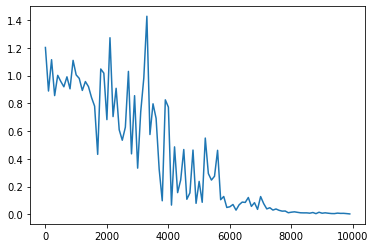

In [5]:
import numpy as np
from common import functions
import matplotlib.pyplot as plt


def d_tanh(x):
    return 1/(np.cosh(x) ** 2)

# データを用意
# 2進数の桁数
binary_dim = 8
# 最大値 + 1
largest_number = pow(2, binary_dim)
# largest_numberまで2進数を用意
binary = np.unpackbits(np.array([range(largest_number)],dtype=np.uint8).T,axis=1)

input_layer_size = 2
hidden_layer_size = 16
output_layer_size = 1

weight_init_std = 1
learning_rate = 0.1

iters_num = 10000
plot_interval = 100

# ウェイト初期化 (バイアスは簡単のため省略)
# W_in = weight_init_std * np.random.randn(input_layer_size, hidden_layer_size)
# W_out = weight_init_std * np.random.randn(hidden_layer_size, output_layer_size)
# W = weight_init_std * np.random.randn(hidden_layer_size, hidden_layer_size)
# Xavier
# W_in = np.random.randn(input_layer_size, hidden_layer_size) / (np.sqrt(input_layer_size))
# W_out = np.random.randn(hidden_layer_size, output_layer_size) / (np.sqrt(hidden_layer_size))
# W = np.random.randn(hidden_layer_size, hidden_layer_size) / (np.sqrt(hidden_layer_size))
# He
W_in = np.random.randn(input_layer_size, hidden_layer_size) / (np.sqrt(input_layer_size)) * np.sqrt(2)
W_out = np.random.randn(hidden_layer_size, output_layer_size) / (np.sqrt(hidden_layer_size)) * np.sqrt(2)
W = np.random.randn(hidden_layer_size, hidden_layer_size) / (np.sqrt(hidden_layer_size)) * np.sqrt(2)


# 勾配
W_in_grad = np.zeros_like(W_in)
W_out_grad = np.zeros_like(W_out)
W_grad = np.zeros_like(W)

u = np.zeros((hidden_layer_size, binary_dim + 1))
z = np.zeros((hidden_layer_size, binary_dim + 1))
y = np.zeros((output_layer_size, binary_dim))

delta_out = np.zeros((output_layer_size, binary_dim))
delta = np.zeros((hidden_layer_size, binary_dim + 1))

all_losses = []

for i in range(iters_num):
    
    # A, B初期化 (a + b = d)
    a_int = np.random.randint(largest_number/2)
    a_bin = binary[a_int] # binary encoding
    b_int = np.random.randint(largest_number/2)
    b_bin = binary[b_int] # binary encoding
    
    # 正解データ
    d_int = a_int + b_int
    d_bin = binary[d_int]
    
    # 出力バイナリ
    out_bin = np.zeros_like(d_bin)
    
    # 時系列全体の誤差
    all_loss = 0    
    
    # 時系列ループ
    for t in range(binary_dim):
        # 入力値
        X = np.array([a_bin[ - t - 1], b_bin[ - t - 1]]).reshape(1, -1)
        # 時刻tにおける正解データ
        dd = np.array([d_bin[binary_dim - t - 1]])
        
        u[:,t+1] = np.dot(X, W_in) + np.dot(z[:,t].reshape(1, -1), W)
        z[:,t+1] = functions.sigmoid(u[:,t+1])
#         z[:,t+1] = functions.relu(u[:,t+1])
#         z[:,t+1] = np.tanh(u[:,t+1])    
        y[:,t] = functions.sigmoid(np.dot(z[:,t+1].reshape(1, -1), W_out))


        #誤差
        loss = functions.mean_squared_error(dd, y[:,t])
        
        delta_out[:,t] = functions.d_mean_squared_error(dd, y[:,t]) * functions.d_sigmoid(y[:,t])        
        
        all_loss += loss

        out_bin[binary_dim - t - 1] = np.round(y[:,t])
    
    
    for t in range(binary_dim)[::-1]:
        X = np.array([a_bin[-t-1],b_bin[-t-1]]).reshape(1, -1)        

        delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_sigmoid(u[:,t+1])
#         delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_relu(u[:,t+1])
#         delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * d_tanh(u[:,t+1])    

        # 勾配更新
        W_out_grad += np.dot(z[:,t+1].reshape(-1,1), delta_out[:,t].reshape(-1,1))
        W_grad += np.dot(z[:,t].reshape(-1,1), delta[:,t].reshape(1,-1))
        W_in_grad += np.dot(X.T, delta[:,t].reshape(1,-1))
    
    # 勾配適用
    W_in -= learning_rate * W_in_grad
    W_out -= learning_rate * W_out_grad
    W -= learning_rate * W_grad
    
    W_in_grad *= 0
    W_out_grad *= 0
    W_grad *= 0
    

    if(i % plot_interval == 0):
        all_losses.append(all_loss)        
        print("iters:" + str(i))
        print("Loss:" + str(all_loss))
        print("Pred:" + str(out_bin))
        print("True:" + str(d_bin))
        out_int = 0
        for index,x in enumerate(reversed(out_bin)):
            out_int += x * pow(2, index)
        print(str(a_int) + " + " + str(b_int) + " = " + str(out_int))
        print("------------")

lists = range(0, iters_num, plot_interval)
plt.plot(lists, all_losses, label="loss")
plt.show()

- He+sigmodでは、初期の学習の進行が比較的早いが、やはり中間で不安定な部分が見られる

/content/drive/My Drive/Study-AI/step4/common/functions.py:6: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-x))


iters:0
Loss:1.0097068850711466
Pred:[0 0 0 0 1 0 0 0]
True:[1 0 1 0 1 0 0 0]
45 + 123 = 8
------------
iters:100
Loss:1.0
Pred:[0 0 0 0 0 0 0 0]
True:[0 1 0 0 1 0 0 1]
20 + 53 = 0
------------
iters:200
Loss:1.4960831240390742
Pred:[0 0 0 0 0 0 0 0]
True:[0 1 0 1 1 1 1 1]
93 + 2 = 0
------------
iters:300
Loss:0.7715456427280558
Pred:[0 0 0 0 1 0 0 1]
True:[1 0 0 1 1 1 0 1]
41 + 116 = 9
------------
iters:400
Loss:0.8858355609261674
Pred:[0 0 0 0 0 1 0 0]
True:[1 1 1 0 0 1 1 0]
108 + 122 = 4
------------
iters:500
Loss:1.360409789103158
Pred:[0 0 0 0 1 0 0 0]
True:[1 0 1 1 0 0 0 0]
90 + 86 = 8
------------
iters:600
Loss:0.8759464770774765
Pred:[0 0 0 0 0 0 0 1]
True:[0 1 1 1 0 1 1 1]
11 + 108 = 1
------------
iters:700
Loss:1.7162396120498513
Pred:[0 0 1 0 0 0 1 0]
True:[1 1 0 0 1 0 0 0]
111 + 89 = 34
------------
iters:800
Loss:1.3270810097599819
Pred:[0 0 1 0 0 0 0 0]
True:[1 0 0 1 1 0 1 0]
61 + 93 = 32
------------
iters:900
Loss:1.3269028706067982
Pred:[0 0 0 0 0 0 0 0]
True:[0 0

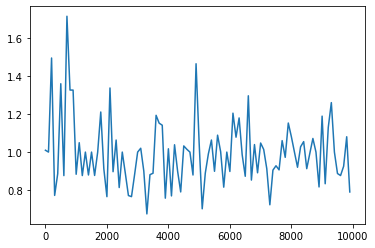

In [12]:
import numpy as np
from common import functions
import matplotlib.pyplot as plt


def d_tanh(x):
    return 1/(np.cosh(x) ** 2)

# データを用意
# 2進数の桁数
binary_dim = 8
# 最大値 + 1
largest_number = pow(2, binary_dim)
# largest_numberまで2進数を用意
binary = np.unpackbits(np.array([range(largest_number)],dtype=np.uint8).T,axis=1)

input_layer_size = 2
hidden_layer_size = 16
output_layer_size = 1

weight_init_std = 1
learning_rate = 0.1

iters_num = 10000
plot_interval = 100

# ウェイト初期化 (バイアスは簡単のため省略)
W_in = weight_init_std * np.random.randn(input_layer_size, hidden_layer_size)
W_out = weight_init_std * np.random.randn(hidden_layer_size, output_layer_size)
W = weight_init_std * np.random.randn(hidden_layer_size, hidden_layer_size)
# Xavier
# W_in = np.random.randn(input_layer_size, hidden_layer_size) / (np.sqrt(input_layer_size))
# W_out = np.random.randn(hidden_layer_size, output_layer_size) / (np.sqrt(hidden_layer_size))
# W = np.random.randn(hidden_layer_size, hidden_layer_size) / (np.sqrt(hidden_layer_size))
# He
# W_in = np.random.randn(input_layer_size, hidden_layer_size) / (np.sqrt(input_layer_size)) * np.sqrt(2)
# W_out = np.random.randn(hidden_layer_size, output_layer_size) / (np.sqrt(hidden_layer_size)) * np.sqrt(2)
# W = np.random.randn(hidden_layer_size, hidden_layer_size) / (np.sqrt(hidden_layer_size)) * np.sqrt(2)


# 勾配
W_in_grad = np.zeros_like(W_in)
W_out_grad = np.zeros_like(W_out)
W_grad = np.zeros_like(W)

u = np.zeros((hidden_layer_size, binary_dim + 1))
z = np.zeros((hidden_layer_size, binary_dim + 1))
y = np.zeros((output_layer_size, binary_dim))

delta_out = np.zeros((output_layer_size, binary_dim))
delta = np.zeros((hidden_layer_size, binary_dim + 1))

all_losses = []

for i in range(iters_num):
    
    # A, B初期化 (a + b = d)
    a_int = np.random.randint(largest_number/2)
    a_bin = binary[a_int] # binary encoding
    b_int = np.random.randint(largest_number/2)
    b_bin = binary[b_int] # binary encoding
    
    # 正解データ
    d_int = a_int + b_int
    d_bin = binary[d_int]
    
    # 出力バイナリ
    out_bin = np.zeros_like(d_bin)
    
    # 時系列全体の誤差
    all_loss = 0    
    
    # 時系列ループ
    for t in range(binary_dim):
        # 入力値
        X = np.array([a_bin[ - t - 1], b_bin[ - t - 1]]).reshape(1, -1)
        # 時刻tにおける正解データ
        dd = np.array([d_bin[binary_dim - t - 1]])
        
        u[:,t+1] = np.dot(X, W_in) + np.dot(z[:,t].reshape(1, -1), W)
        # z[:,t+1] = functions.sigmoid(u[:,t+1])
        z[:,t+1] = functions.relu(u[:,t+1])
#         z[:,t+1] = np.tanh(u[:,t+1])    
        y[:,t] = functions.sigmoid(np.dot(z[:,t+1].reshape(1, -1), W_out))


        #誤差
        loss = functions.mean_squared_error(dd, y[:,t])
        
        delta_out[:,t] = functions.d_mean_squared_error(dd, y[:,t]) * functions.d_sigmoid(y[:,t])        
        
        all_loss += loss

        out_bin[binary_dim - t - 1] = np.round(y[:,t])
    
    
    for t in range(binary_dim)[::-1]:
        X = np.array([a_bin[-t-1],b_bin[-t-1]]).reshape(1, -1)        

        # delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_sigmoid(u[:,t+1])
        delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_relu(u[:,t+1])
#         delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * d_tanh(u[:,t+1])    

        # 勾配更新
        W_out_grad += np.dot(z[:,t+1].reshape(-1,1), delta_out[:,t].reshape(-1,1))
        W_grad += np.dot(z[:,t].reshape(-1,1), delta[:,t].reshape(1,-1))
        W_in_grad += np.dot(X.T, delta[:,t].reshape(1,-1))
    
    # 勾配適用
    W_in -= learning_rate * W_in_grad
    W_out -= learning_rate * W_out_grad
    W -= learning_rate * W_grad
    
    W_in_grad *= 0
    W_out_grad *= 0
    W_grad *= 0
    

    if(i % plot_interval == 0):
        all_losses.append(all_loss)        
        print("iters:" + str(i))
        print("Loss:" + str(all_loss))
        print("Pred:" + str(out_bin))
        print("True:" + str(d_bin))
        out_int = 0
        for index,x in enumerate(reversed(out_bin)):
            out_int += x * pow(2, index)
        print(str(a_int) + " + " + str(b_int) + " = " + str(out_int))
        print("------------")

lists = range(0, iters_num, plot_interval)
plt.plot(lists, all_losses, label="loss")
plt.show()

iters:0
Loss:1.3740366222932527
Pred:[1 1 1 1 1 1 1 0]
True:[0 1 1 0 1 0 1 0]
80 + 26 = 254
------------
iters:100
Loss:0.7309245432917136
Pred:[0 1 1 1 1 1 1 1]
True:[0 0 1 1 0 1 1 1]
20 + 35 = 127
------------
iters:200
Loss:0.8016526143935861
Pred:[0 1 1 1 1 0 0 1]
True:[0 0 0 1 1 0 0 1]
23 + 2 = 121
------------
iters:300
Loss:0.7980455868604791
Pred:[0 1 1 0 1 0 0 1]
True:[0 1 1 1 0 0 0 1]
11 + 102 = 105
------------
iters:400
Loss:1.2354707102314122
Pred:[1 1 0 1 0 0 1 0]
True:[1 0 1 0 1 0 0 0]
57 + 111 = 210
------------
iters:500
Loss:0.4640121181797245
Pred:[1 1 0 0 0 1 0 1]
True:[1 0 0 0 0 1 0 1]
83 + 50 = 197
------------
iters:600
Loss:0.6477042078867888
Pred:[1 1 0 1 1 0 1 1]
True:[1 0 0 1 1 1 1 1]
109 + 50 = 219
------------
iters:700
Loss:0.3899187276425359
Pred:[1 1 0 1 0 1 0 1]
True:[1 1 0 1 0 0 0 1]
103 + 106 = 213
------------
iters:800
Loss:0.9439975645324872
Pred:[1 1 0 1 1 1 1 1]
True:[1 0 0 0 1 1 0 1]
22 + 119 = 223
------------
iters:900
Loss:0.5511711027250673


/content/drive/My Drive/Study-AI/step4/common/functions.py:6: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-x))


iters:3800
Loss:1.0
Pred:[0 0 0 0 0 0 0 0]
True:[1 0 1 0 0 1 0 0]
94 + 70 = 0
------------
iters:3900
Loss:1.0
Pred:[0 0 0 0 0 0 0 0]
True:[0 1 0 1 1 0 1 0]
46 + 44 = 0
------------
iters:4000
Loss:1.0
Pred:[0 0 0 0 0 0 0 0]
True:[0 1 0 1 1 0 0 1]
2 + 87 = 0
------------
iters:4100
Loss:1.0
Pred:[0 0 0 0 0 0 0 0]
True:[0 1 0 0 1 0 0 1]
16 + 57 = 0
------------
iters:4200
Loss:1.0
Pred:[0 0 0 0 0 0 0 0]
True:[1 0 1 1 1 0 1 0]
116 + 70 = 0
------------
iters:4300
Loss:1.0
Pred:[0 0 0 0 0 0 0 0]
True:[0 0 1 1 0 1 0 1]
47 + 6 = 0
------------
iters:4400
Loss:1.0
Pred:[0 0 0 0 0 0 0 0]
True:[0 0 1 1 0 0 0 1]
20 + 29 = 0
------------
iters:4500
Loss:1.0
Pred:[0 0 0 0 0 0 0 0]
True:[0 1 0 1 1 1 1 0]
6 + 88 = 0
------------
iters:4600
Loss:1.0
Pred:[0 0 0 0 0 0 0 0]
True:[0 1 0 0 1 0 0 1]
72 + 1 = 0
------------
iters:4700
Loss:1.0
Pred:[0 0 0 0 0 0 0 0]
True:[0 1 0 0 1 0 0 1]
14 + 59 = 0
------------
iters:4800
Loss:1.0
Pred:[0 0 0 0 0 0 0 0]
True:[0 0 1 1 0 1 1 1]
14 + 41 = 0
------------
it

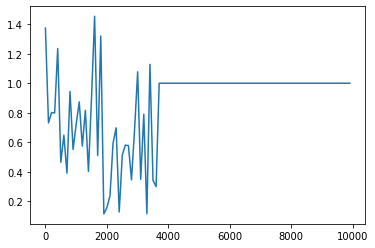

In [15]:
import numpy as np
from common import functions
import matplotlib.pyplot as plt


def d_tanh(x):
    return 1/(np.cosh(x) ** 2)

# データを用意
# 2進数の桁数
binary_dim = 8
# 最大値 + 1
largest_number = pow(2, binary_dim)
# largest_numberまで2進数を用意
binary = np.unpackbits(np.array([range(largest_number)],dtype=np.uint8).T,axis=1)

input_layer_size = 2
hidden_layer_size = 16
output_layer_size = 1

weight_init_std = 1
learning_rate = 0.1

iters_num = 10000
plot_interval = 100

# ウェイト初期化 (バイアスは簡単のため省略)
# W_in = weight_init_std * np.random.randn(input_layer_size, hidden_layer_size)
# W_out = weight_init_std * np.random.randn(hidden_layer_size, output_layer_size)
# W = weight_init_std * np.random.randn(hidden_layer_size, hidden_layer_size)
# Xavier
# W_in = np.random.randn(input_layer_size, hidden_layer_size) / (np.sqrt(input_layer_size))
# W_out = np.random.randn(hidden_layer_size, output_layer_size) / (np.sqrt(hidden_layer_size))
# W = np.random.randn(hidden_layer_size, hidden_layer_size) / (np.sqrt(hidden_layer_size))
# He
W_in = np.random.randn(input_layer_size, hidden_layer_size) / (np.sqrt(input_layer_size)) * np.sqrt(2)
W_out = np.random.randn(hidden_layer_size, output_layer_size) / (np.sqrt(hidden_layer_size)) * np.sqrt(2)
W = np.random.randn(hidden_layer_size, hidden_layer_size) / (np.sqrt(hidden_layer_size)) * np.sqrt(2)


# 勾配
W_in_grad = np.zeros_like(W_in)
W_out_grad = np.zeros_like(W_out)
W_grad = np.zeros_like(W)

u = np.zeros((hidden_layer_size, binary_dim + 1))
z = np.zeros((hidden_layer_size, binary_dim + 1))
y = np.zeros((output_layer_size, binary_dim))

delta_out = np.zeros((output_layer_size, binary_dim))
delta = np.zeros((hidden_layer_size, binary_dim + 1))

all_losses = []

for i in range(iters_num):
    
    # A, B初期化 (a + b = d)
    a_int = np.random.randint(largest_number/2)
    a_bin = binary[a_int] # binary encoding
    b_int = np.random.randint(largest_number/2)
    b_bin = binary[b_int] # binary encoding
    
    # 正解データ
    d_int = a_int + b_int
    d_bin = binary[d_int]
    
    # 出力バイナリ
    out_bin = np.zeros_like(d_bin)
    
    # 時系列全体の誤差
    all_loss = 0    
    
    # 時系列ループ
    for t in range(binary_dim):
        # 入力値
        X = np.array([a_bin[ - t - 1], b_bin[ - t - 1]]).reshape(1, -1)
        # 時刻tにおける正解データ
        dd = np.array([d_bin[binary_dim - t - 1]])
        
        u[:,t+1] = np.dot(X, W_in) + np.dot(z[:,t].reshape(1, -1), W)
        # z[:,t+1] = functions.sigmoid(u[:,t+1])
        z[:,t+1] = functions.relu(u[:,t+1])
#         z[:,t+1] = np.tanh(u[:,t+1])    
        y[:,t] = functions.sigmoid(np.dot(z[:,t+1].reshape(1, -1), W_out))


        #誤差
        loss = functions.mean_squared_error(dd, y[:,t])
        
        delta_out[:,t] = functions.d_mean_squared_error(dd, y[:,t]) * functions.d_sigmoid(y[:,t])        
        
        all_loss += loss

        out_bin[binary_dim - t - 1] = np.round(y[:,t])
    
    
    for t in range(binary_dim)[::-1]:
        X = np.array([a_bin[-t-1],b_bin[-t-1]]).reshape(1, -1)        

        # delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_sigmoid(u[:,t+1])
        delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_relu(u[:,t+1])
#         delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * d_tanh(u[:,t+1])    

        # 勾配更新
        W_out_grad += np.dot(z[:,t+1].reshape(-1,1), delta_out[:,t].reshape(-1,1))
        W_grad += np.dot(z[:,t].reshape(-1,1), delta[:,t].reshape(1,-1))
        W_in_grad += np.dot(X.T, delta[:,t].reshape(1,-1))
    
    # 勾配適用
    W_in -= learning_rate * W_in_grad
    W_out -= learning_rate * W_out_grad
    W -= learning_rate * W_grad
    
    W_in_grad *= 0
    W_out_grad *= 0
    W_grad *= 0
    

    if(i % plot_interval == 0):
        all_losses.append(all_loss)        
        print("iters:" + str(i))
        print("Loss:" + str(all_loss))
        print("Pred:" + str(out_bin))
        print("True:" + str(d_bin))
        out_int = 0
        for index,x in enumerate(reversed(out_bin)):
            out_int += x * pow(2, index)
        print(str(a_int) + " + " + str(b_int) + " = " + str(out_int))
        print("------------")

lists = range(0, iters_num, plot_interval)
plt.plot(lists, all_losses, label="loss")
plt.show()

- ReLUでは、初期重みを変えても学習が安定せず、実行のたびに結果が大きく変わってしまう＝勾配爆発が考えられる

iters:0
Loss:2.067048621471274
Pred:[0 0 0 0 0 0 0 0]
True:[1 1 0 1 1 1 1 1]
96 + 127 = 0
------------
iters:100
Loss:1.2207691660117281
Pred:[0 0 0 0 0 1 0 0]
True:[0 1 0 1 0 0 1 0]
64 + 18 = 4
------------
iters:200
Loss:1.0453047788787737
Pred:[0 1 0 1 1 1 0 1]
True:[1 0 0 0 0 0 1 1]
94 + 37 = 93
------------
iters:300
Loss:0.7756308120552103
Pred:[1 0 1 1 0 1 0 0]
True:[0 1 1 1 0 1 0 0]
34 + 82 = 180
------------
iters:400
Loss:1.0992468093595036
Pred:[0 0 1 0 0 0 1 0]
True:[1 0 0 0 0 0 1 0]
100 + 30 = 34
------------
iters:500
Loss:0.7508579449530925
Pred:[0 0 0 1 0 0 1 0]
True:[0 1 0 0 0 0 1 0]
19 + 47 = 18
------------
iters:600
Loss:0.4877441851040172
Pred:[0 1 1 1 1 1 1 1]
True:[0 1 1 1 1 0 1 1]
109 + 14 = 127
------------
iters:700
Loss:0.3508779312565634
Pred:[0 0 1 1 0 0 0 0]
True:[0 0 1 1 0 0 0 0]
18 + 30 = 48
------------
iters:800
Loss:0.22294066154329042
Pred:[0 1 0 1 0 0 0 0]
True:[0 1 0 1 0 0 0 0]
13 + 67 = 80
------------
iters:900
Loss:0.3611739108777271
Pred:[0 1 0

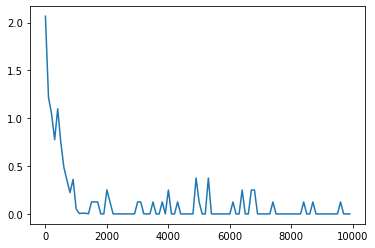

In [16]:
import numpy as np
from common import functions
import matplotlib.pyplot as plt


def d_tanh(x):
    return 1/(np.cosh(x) ** 2)

# データを用意
# 2進数の桁数
binary_dim = 8
# 最大値 + 1
largest_number = pow(2, binary_dim)
# largest_numberまで2進数を用意
binary = np.unpackbits(np.array([range(largest_number)],dtype=np.uint8).T,axis=1)

input_layer_size = 2
hidden_layer_size = 16
output_layer_size = 1

weight_init_std = 1
learning_rate = 0.1

iters_num = 10000
plot_interval = 100

# ウェイト初期化 (バイアスは簡単のため省略)
# W_in = weight_init_std * np.random.randn(input_layer_size, hidden_layer_size)
# W_out = weight_init_std * np.random.randn(hidden_layer_size, output_layer_size)
# W = weight_init_std * np.random.randn(hidden_layer_size, hidden_layer_size)
# Xavier
# W_in = np.random.randn(input_layer_size, hidden_layer_size) / (np.sqrt(input_layer_size))
# W_out = np.random.randn(hidden_layer_size, output_layer_size) / (np.sqrt(hidden_layer_size))
# W = np.random.randn(hidden_layer_size, hidden_layer_size) / (np.sqrt(hidden_layer_size))
# He
W_in = np.random.randn(input_layer_size, hidden_layer_size) / (np.sqrt(input_layer_size)) * np.sqrt(2)
W_out = np.random.randn(hidden_layer_size, output_layer_size) / (np.sqrt(hidden_layer_size)) * np.sqrt(2)
W = np.random.randn(hidden_layer_size, hidden_layer_size) / (np.sqrt(hidden_layer_size)) * np.sqrt(2)


# 勾配
W_in_grad = np.zeros_like(W_in)
W_out_grad = np.zeros_like(W_out)
W_grad = np.zeros_like(W)

u = np.zeros((hidden_layer_size, binary_dim + 1))
z = np.zeros((hidden_layer_size, binary_dim + 1))
y = np.zeros((output_layer_size, binary_dim))

delta_out = np.zeros((output_layer_size, binary_dim))
delta = np.zeros((hidden_layer_size, binary_dim + 1))

all_losses = []

for i in range(iters_num):
    
    # A, B初期化 (a + b = d)
    a_int = np.random.randint(largest_number/2)
    a_bin = binary[a_int] # binary encoding
    b_int = np.random.randint(largest_number/2)
    b_bin = binary[b_int] # binary encoding
    
    # 正解データ
    d_int = a_int + b_int
    d_bin = binary[d_int]
    
    # 出力バイナリ
    out_bin = np.zeros_like(d_bin)
    
    # 時系列全体の誤差
    all_loss = 0    
    
    # 時系列ループ
    for t in range(binary_dim):
        # 入力値
        X = np.array([a_bin[ - t - 1], b_bin[ - t - 1]]).reshape(1, -1)
        # 時刻tにおける正解データ
        dd = np.array([d_bin[binary_dim - t - 1]])
        
        u[:,t+1] = np.dot(X, W_in) + np.dot(z[:,t].reshape(1, -1), W)
        # z[:,t+1] = functions.sigmoid(u[:,t+1])
#         z[:,t+1] = functions.relu(u[:,t+1])
        z[:,t+1] = np.tanh(u[:,t+1])    
        y[:,t] = functions.sigmoid(np.dot(z[:,t+1].reshape(1, -1), W_out))


        #誤差
        loss = functions.mean_squared_error(dd, y[:,t])
        
        delta_out[:,t] = functions.d_mean_squared_error(dd, y[:,t]) * functions.d_sigmoid(y[:,t])        
        
        all_loss += loss

        out_bin[binary_dim - t - 1] = np.round(y[:,t])
    
    
    for t in range(binary_dim)[::-1]:
        X = np.array([a_bin[-t-1],b_bin[-t-1]]).reshape(1, -1)        

        # delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_sigmoid(u[:,t+1])
        # delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_relu(u[:,t+1])
        delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * d_tanh(u[:,t+1])    

        # 勾配更新
        W_out_grad += np.dot(z[:,t+1].reshape(-1,1), delta_out[:,t].reshape(-1,1))
        W_grad += np.dot(z[:,t].reshape(-1,1), delta[:,t].reshape(1,-1))
        W_in_grad += np.dot(X.T, delta[:,t].reshape(1,-1))
    
    # 勾配適用
    W_in -= learning_rate * W_in_grad
    W_out -= learning_rate * W_out_grad
    W -= learning_rate * W_grad
    
    W_in_grad *= 0
    W_out_grad *= 0
    W_grad *= 0
    

    if(i % plot_interval == 0):
        all_losses.append(all_loss)        
        print("iters:" + str(i))
        print("Loss:" + str(all_loss))
        print("Pred:" + str(out_bin))
        print("True:" + str(d_bin))
        out_int = 0
        for index,x in enumerate(reversed(out_bin)):
            out_int += x * pow(2, index)
        print(str(a_int) + " + " + str(b_int) + " = " + str(out_int))
        print("------------")

lists = range(0, iters_num, plot_interval)
plt.plot(lists, all_losses, label="loss")
plt.show()

- He+tanhでは、学習が素早く進んでおり安定している